In [1]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import joblib
from openpyxl import load_workbook

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Bibliotecas dos Modelos Utilizados
from sklearn.tree import DecisionTreeClassifier      # Árvore de Decisões de Classificação.
from sklearn.ensemble import RandomForestClassifier  # Floresta Aleatória.
from xgboost import XGBClassifier                    # Extreme Gradient Boosting.

In [3]:
# Análise de Dados
from sklearn.decomposition import PCA

# Treinamento
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Avalição
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import label_binarize

# Tuning
from sklearn.model_selection import GridSearchCV

# Análise de Dados

In [77]:
# Carregar o DataFrame a partir de um arquivo Excel
caminho_arquivo_excel = 'C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\anonymizedData.xlsx'
nome_da_pagina = 'P_Frenagem'  # Nome da página desejada

# Lê o arquivo Excel com todas as páginas/sheets
xl = pd.ExcelFile(caminho_arquivo_excel)

df = xl.parse(nome_da_pagina)

# Vê dados 
df.head()

,DP_Entre-Eixo,DP_Bitola Dianteira,DP_Bitola Traseira,DP_Altura,DP_Comprimento,DP_Altura do CG com relacao ao chao,MV_Eixo dianteiro,MV_Eixo Traseiro,DMV_Dianteira,DMV_Lado Direito,...,CD_Distancia de frenagem de 35 a 0 em asfalto,CD_Distancia de frenagem de 35 a 0 em terra batida,CD_Ganho de rolagem por aceleracao lateral,CD_Ganho de arfagem em aceleracao longitudinal,CD_Ganho de arfagem em desaceleracao longitudinal,CD_Velocidade maxima de 0 a 100 metros em asfalto,CD_Velocidade maxima de 0 a 100 metros em terra batida,CD_Tempo para atingir velocidade maxima em asfalto,CD_Tempo para atingir velocidade maxima em terra batida,P_Frenagem
0,1393.304461,1339.523445,1200.000000,568.132661,1898.902413,550.000000,69.725413,139.027996,0.380331,0.593223,...,NaN,NaN,NaN,NaN,NaN,NaN,42.139486,NaN,NaN,1
1,1447.028832,1330.136525,1361.481906,1505.363554,2079.855119,374.265277,74.859956,94.351698,0.411191,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1360.497021,1300.548245,1229.410830,2034.755114,2073.610993,525.174720,79.479623,98.184666,0.414025,0.562029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1375.720704,1285.067917,1267.613713,2238.367796,2017.352229,451.574651,65.639500,86.142680,0.416392,0.510369,...,NaN,NaN,3.899899,2.011436,3.056203,58.0,55.922387,7.163712,7.754569,1
4,1412.899313,1318.765014,1200.000000,1449.569054,2065.365531,534.234474,78.846482,115.531577,0.388342,0.522544,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [80]:
# Linha a ser adicionada
linha = "1380,0000/ 1300/ 1190,0000/ 1551,7200/ 1880/ 469,6/ 114,32/ 86,58/ 0,432/ 0,519/ 629,4/ 788,8/ 189,6000/ 170/ 62/ 22,0000/ 0/ 0/ 245/ 62/ 22/ 0/ 0/ 2/ 69,4/6,8000/ 15/ 39/ 370,3/ 81/ 180/ 52/ 160,0000/ 7,0800/ 20,7/ 38/ 9,5/ 2080/ 30/ 6,4699/ 8,7287/ 3,6/ 0/ 0/ 43/ 41/ 4,2/ 4,4/ 5/"

# Separar os valores da linha
valores = linha.split("/")

# Converter os valores para float
valores_float = [float(valor.replace(",", ".")) for valor in valores[:-1]]

# Adicionar a nova linha ao final do DataFrame existente
df.loc[len(df)] = valores_float

# Verificar o DataFrame atualizado
print(df)

      DP_Entre-Eixo  DP_Bitola Dianteira  DP_Bitola Traseira    DP_Altura  \
0       1393.304461          1339.523445         1200.000000   568.132661   
1       1447.028832          1330.136525         1361.481906  1505.363554   
2       1360.497021          1300.548245         1229.410830  2034.755114   
3       1375.720704          1285.067917         1267.613713  2238.367796   
4       1412.899313          1318.765014         1200.000000  1449.569054   
...             ...                  ...                 ...          ...   
996     1339.089526          1380.357851         1246.393111   669.952762   
997     1337.638166          1313.913083         1232.045423  1540.791945   
998     1400.000000          1349.121854         1217.674135  1501.580522   
999     1361.110835          1385.156045         1238.253324  1003.928144   
1000    1380.000000          1300.000000         1190.000000  1551.720000   

      DP_Comprimento  DP_Altura do CG com relacao ao chao  MV_Eixo dianteir

In [81]:
# Remove as colunas que não trazem dados relevantes as provas
colunas_a_remover = [
    'DP_Entre-Eixo',
    'DP_Bitola Dianteira',
    'DP_Bitola Traseira',
    'DP_Altura',
    'DP_Comprimento',
    'DMV_Lado Direito',
    'ST_Curso Positivo de projeto',
    'SD_Curso Positivo de projeto',
    'SD_Curso Negativo de projeto',
    'ST_Curso Negativo de projeto',
    'D_Relacao',
    'D_Curso total da cremalheira',
    'D_Inclinacao do pino mestre',
    'D_Angulo de caster',
    'CD_Raio mínimo de curva do protótipo',
    'CD_Velocidade crítica para uma curva de raio de 10 m',
    'CD_Ganho de rolagem por aceleracao lateral',
    'CD_Ganho de arfagem em aceleracao longitudinal',
    'CD_Ganho de arfagem em desaceleracao longitudinal'
]

# Remove as colunas especificadas
df = df.drop(colunas_a_remover, axis=1)

In [82]:
# Informação básica
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001 entries, 0 to 1000
Data columns (total 30 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   DP_Altura do CG com relacao ao chao                      991 non-null    float64
 1   MV_Eixo dianteiro                                        1001 non-null   float64
 2   MV_Eixo Traseiro                                         1001 non-null   float64
 3   DMV_Dianteira                                            1001 non-null   float64
 4   PCG_X                                                    1001 non-null   float64
 5   PCG_Y                                                    1001 non-null   float64
 6   PCG_Z                                                    1001 non-null   float64
 7   SD_Dimensoes dos pneus                                   1001 non-null   float64
 8   SD_Cambagem estatica        

In [83]:
#Descrição de dados
df.describe()

,DP_Altura do CG com relacao ao chao,MV_Eixo dianteiro,MV_Eixo Traseiro,DMV_Dianteira,PCG_X,PCG_Y,PCG_Z,SD_Dimensoes dos pneus,SD_Cambagem estatica,SD_Convergência estatica,...,MT_Torque maximo do motor,MT_Relacao total_max,MT_Relacao total_min,CD_Distancia de frenagem de 35 a 0 em asfalto,CD_Distancia de frenagem de 35 a 0 em terra batida,CD_Velocidade maxima de 0 a 100 metros em asfalto,CD_Velocidade maxima de 0 a 100 metros em terra batida,CD_Tempo para atingir velocidade maxima em asfalto,CD_Tempo para atingir velocidade maxima em terra batida,P_Frenagem
count,991.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,837.000000,755.000000,...,1001.000000,951.000000,895.000000,191.000000,247.000000,362.000000,240.000000,270.000000,204.000000,1001.000000
mean,533.390931,77.485327,106.413899,0.420773,142.244585,23.967357,202.814930,20.277722,-0.234421,0.022762,...,19.267659,28.837590,6.228915,4.874757,6.668285,48.476056,44.242511,9.554990,11.179810,3.001998
std,94.464538,9.631247,13.585631,0.024441,134.844219,67.038458,113.861061,6.079374,0.576130,0.379548,...,1.101720,4.639375,1.167386,1.100886,1.623479,4.304310,4.968971,4.244857,5.063434,1.415626
min,281.512292,54.078316,75.323941,0.338735,-263.462383,-105.459839,0.513161,0.000000,-3.764598,-1.934054,...,13.878079,3.283746,0.712082,2.177447,2.540235,40.202674,30.130178,4.200000,4.400000,1.000000
25%,491.442472,70.715560,96.796200,0.404324,72.546643,-4.000000,142.608702,21.000000,-0.254962,0.000000,...,18.674613,26.931580,5.479111,4.198691,5.678034,45.273454,40.406212,7.147017,8.601000,2.000000
50%,532.309931,76.412541,105.917529,0.418542,108.586014,3.930791,196.671339,22.000000,0.000000,0.000000,...,18.988759,28.485979,6.233658,4.882048,6.923130,48.020594,43.370844,8.841022,10.468762,3.000000
75%,567.939793,82.461062,114.469576,0.435407,157.029806,38.798946,244.137860,23.000000,0.000000,0.000000,...,19.852516,31.576303,6.933568,5.539914,7.993398,51.599711,46.982638,10.629991,12.229188,4.000000
max,1058.500831,115.618182,172.880844,0.482233,703.179912,788.800000,955.838229,23.000000,1.999325,1.422454,...,23.000000,40.539802,9.813853,7.270000,9.629296,62.823866,62.184199,30.955267,32.977558,5.000000


In [85]:
# Inicialize um dicionário para armazenar o número de zeros em cada coluna
contagem_zeros = {}

# Loop através de todas as colunas
for coluna in df.columns:
    # Use a função sum() para contar a quantidade de zeros (0) na coluna
    zeros_na_coluna = (df[coluna] == 0).sum()
    
    # Armazene o resultado no dicionário
    contagem_zeros[coluna] = zeros_na_coluna

# Exiba a contagem de zeros em cada coluna
for coluna, zeros in contagem_zeros.items():
    print(f"'{coluna}' tem {zeros}.")    

'DP_Altura do CG com relacao ao chao' tem 0.
'MV_Eixo dianteiro' tem 0.
'MV_Eixo Traseiro' tem 0.
'DMV_Dianteira' tem 0.
'PCG_X' tem 0.
'PCG_Y' tem 10.
'PCG_Z' tem 0.
'SD_Dimensoes dos pneus' tem 81.
'SD_Cambagem estatica' tem 573.
'SD_Convergência estatica' tem 548.
'ST_Dimensoes dos pneus' tem 81.
'ST_Cambagem estatica' tem 614.
'ST_Convergência estatica' tem 566.
'FD_Pressao no sistema a 07g ' tem 0.
'FD_Forca no pedal a 07g ' tem 0.
'FD_Curso total do pedal ' tem 0.
'FD_Diametro do disco ' tem 0.
'FT_Pressao no sistema a 07g ' tem 0.
'FT_Diametro do disco ' tem 0.
'MT_Potência maxima do motor' tem 0.
'MT_Torque maximo do motor' tem 0.
'MT_Relacao total_max' tem 0.
'MT_Relacao total_min' tem 0.
'CD_Distancia de frenagem de 35 a 0 em asfalto' tem 0.
'CD_Distancia de frenagem de 35 a 0 em terra batida' tem 0.
'CD_Velocidade maxima de 0 a 100 metros em asfalto ' tem 0.
'CD_Velocidade maxima de 0 a 100 metros em terra batida ' tem 0.
'CD_Tempo para atingir velocidade maxima em asfalto' 

## Limpeza

In [86]:
# Limpar o Dataset das colunas com muitos valores nulos

limite_nulos = 700 # Define o limite de valores nulos permitidos

# Remove as colunas com mais de limite_nulos valores nulos
df = df.dropna(thresh=len(df) - limite_nulos, axis=1)

# Checar 
df.isnull().sum()

DP_Altura do CG com relacao ao chao                    10
MV_Eixo dianteiro                                       0
MV_Eixo Traseiro                                        0
DMV_Dianteira                                           0
PCG_X                                                   0
PCG_Y                                                   0
PCG_Z                                                   0
SD_Dimensoes dos pneus                                  0
SD_Cambagem estatica                                  164
SD_Convergência estatica                              246
ST_Dimensoes dos pneus                                  0
ST_Cambagem estatica                                  201
ST_Convergência estatica                              305
FD_Pressao no sistema a 07g                           556
FD_Forca no pedal a 07g                               557
FD_Curso total do pedal                               467
FD_Diametro do disco                                    0
FT_Pressao no 

In [87]:
# Verifique quais linhas têm mais de 8 valores iguais nulos
linhas_quase_nulas = df[df.isnull().sum(axis=1) > 6]

# Exiba as linhas que atendem à condição
print(linhas_quase_nulas.index)

# Exclua as linhas com base nos índices coletados
df = df.drop(linhas_quase_nulas.index)

# Exiba o DataFrame resultante
print(df)

Int64Index([  4,   5,  13,  14,  23,  25,  26,  27,  28,  33,
            ...
            756, 759, 762, 766, 767, 776, 777, 779, 786, 792],
           dtype='int64', length=171)
      DP_Altura do CG com relacao ao chao  MV_Eixo dianteiro  \
0                              550.000000          69.725413   
1                              374.265277          74.859956   
2                              525.174720          79.479623   
3                              451.574651          65.639500   
6                              549.080563          68.341840   
...                                   ...                ...   
996                            568.409717          81.979805   
997                            734.333973          83.343608   
998                            541.382367          80.391301   
999                            519.540383          91.018978   
1000                           469.600000         114.320000   

      MV_Eixo Traseiro  DMV_Dianteira       PCG_X   

In [88]:
# Pela análise dos dados se percebe que as colunas de Dimensões de Pneus trazem muitos valores zerados
df = df.drop(['SD_Dimensoes dos pneus'], axis=1)
df = df.drop(['ST_Dimensoes dos pneus'], axis=1)

In [89]:
# Mapeie os valores existentes para os novos valores
mapeamento = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}

# Use a função 'replace' para fazer a substituição
df['P_Frenagem'] = df['P_Frenagem'].replace(mapeamento)

print(df['P_Frenagem'])

0       0.0
1       0.0
2       0.0
3       0.0
6       0.0
       ... 
996     4.0
997     4.0
998     4.0
999     4.0
1000    4.0
Name: P_Frenagem, Length: 830, dtype: float64


In [90]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Arquivo_Processado.xlsx"

# Adicionar o DataFrame na planilha 'P_Frenagem'
df.to_excel(excel_writer, sheet_name='P_Frenagem', index=False)

NameError: name 'excel_writer' is not defined

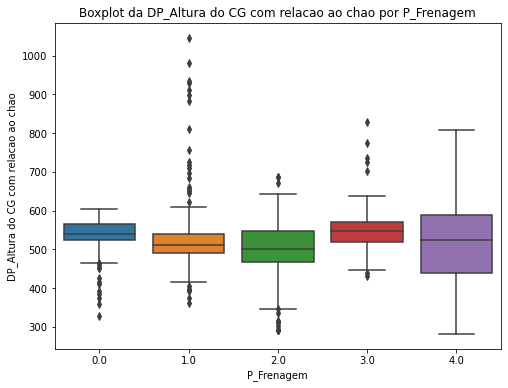

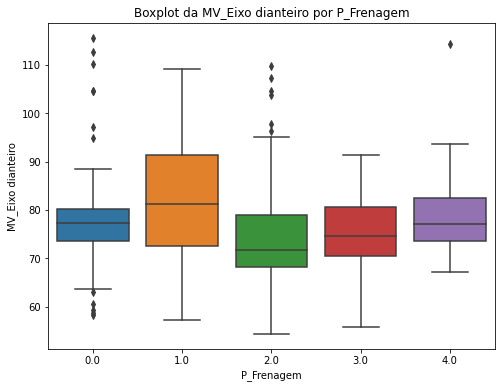

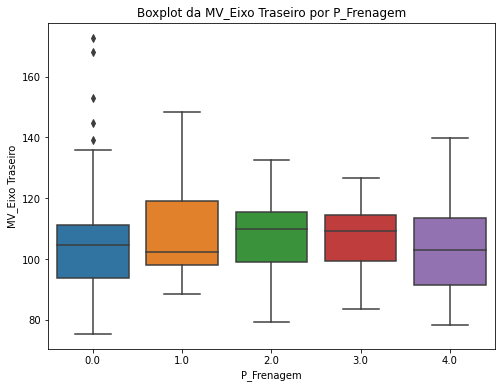

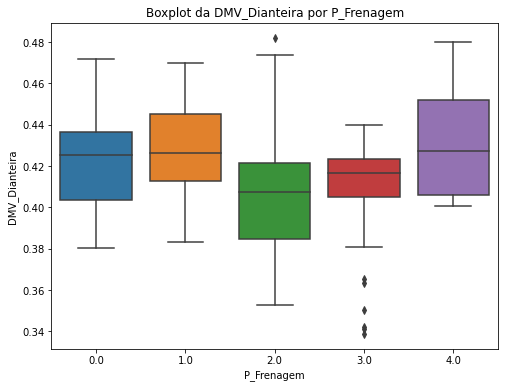

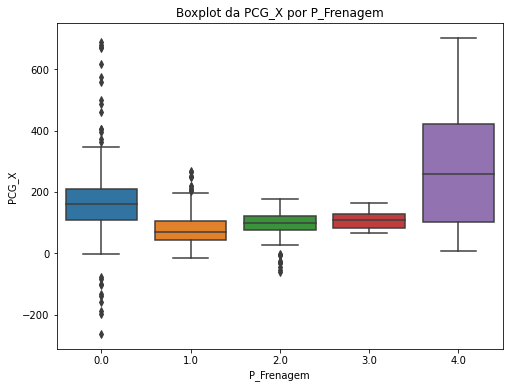

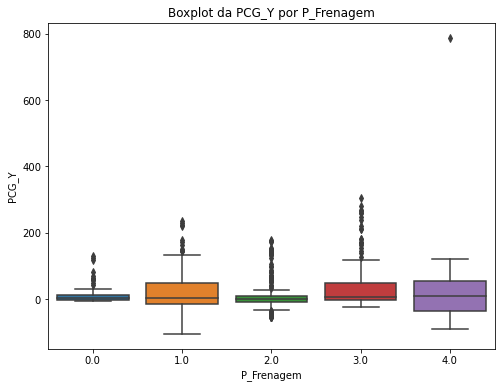

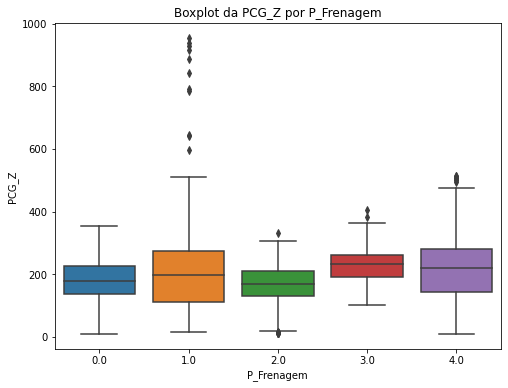

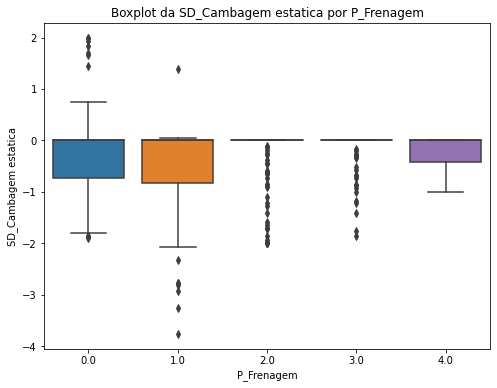

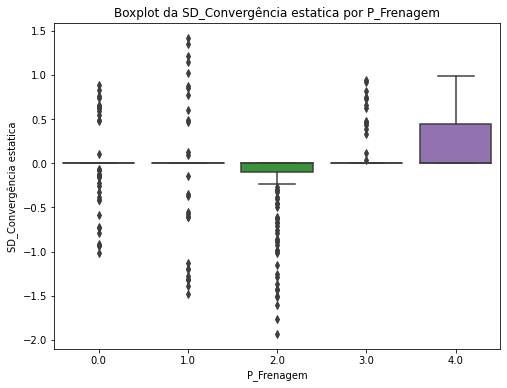

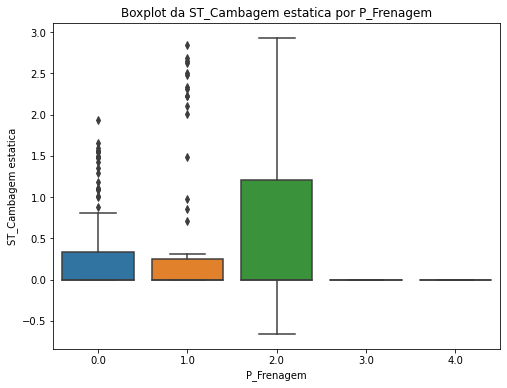

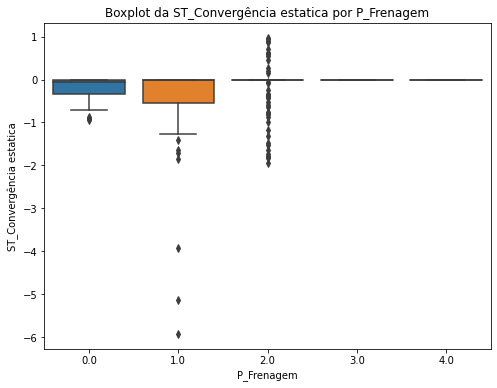

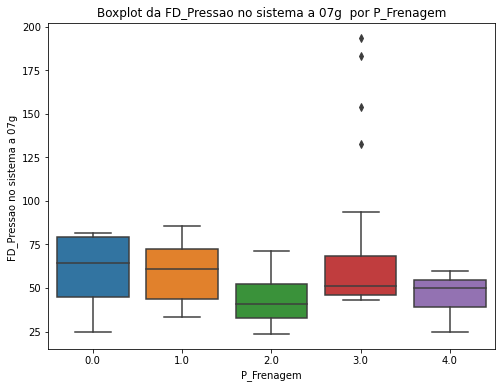

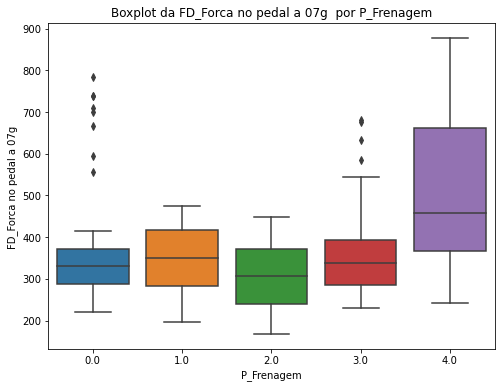

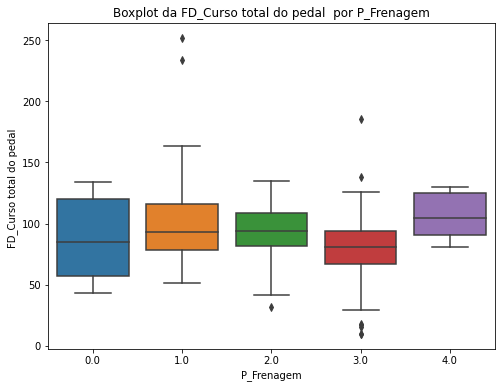

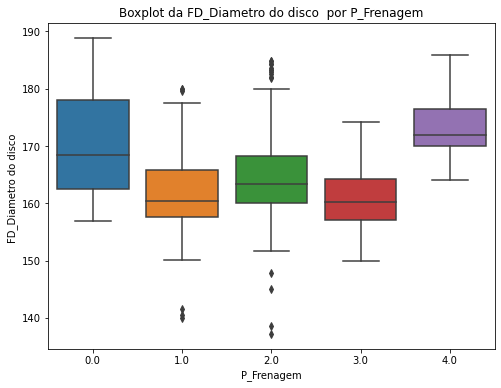

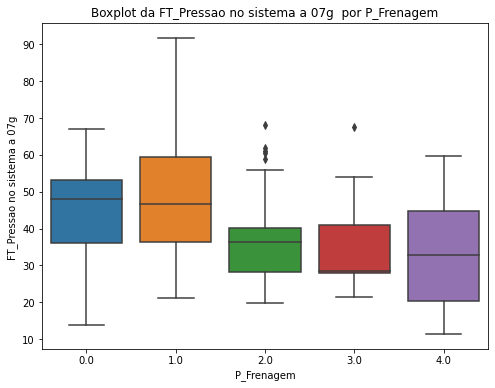

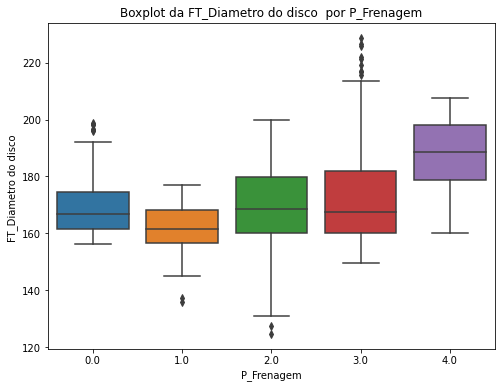

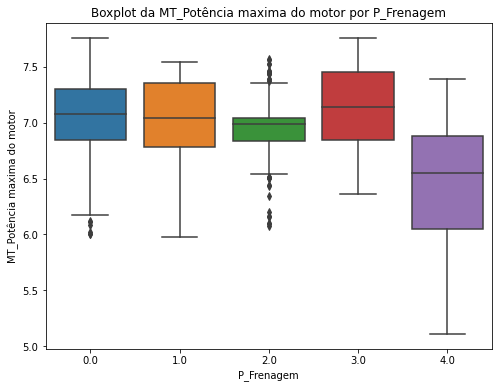

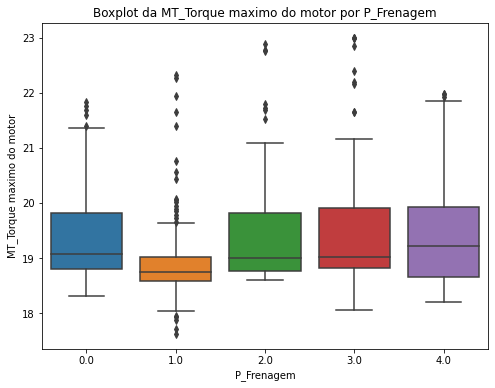

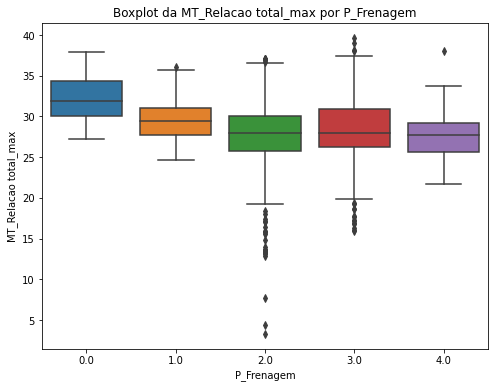

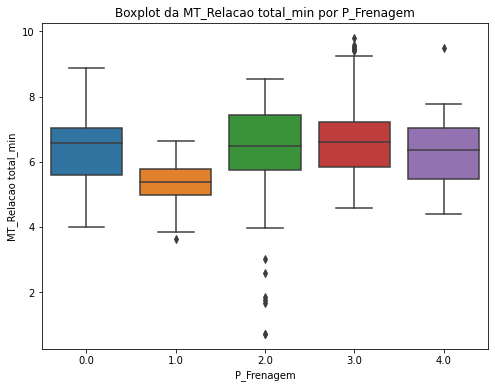

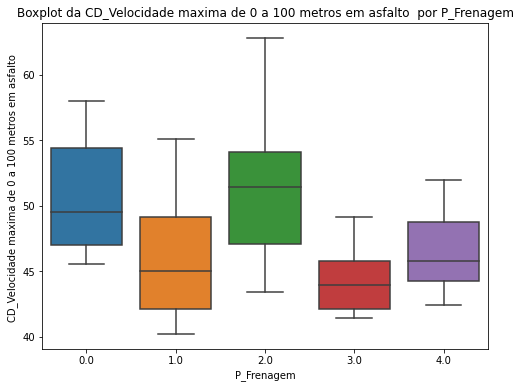

In [91]:
# Boxplots por Classes
for coluna in df.columns:
    if coluna != 'P_Frenagem':  # Excluindo a coluna de classe das análises
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='P_Frenagem', y=coluna, data=df)
        plt.title(f'Boxplot da {coluna} por P_Frenagem')
        plt.ylabel(coluna)
        plt.xlabel('P_Frenagem')
        plt.show()

In [92]:
# Tratar Outliers e valores nulos
colunas_a_tratar = df.columns.difference(['P_Frenagem']) # Lista das colunas a serem tratadas 


# Lista das classes únicas na coluna 'Classe'
classes_unicas = df['P_Frenagem'].unique()

# Função para tratar uma coluna específica em uma classe
def tratar_coluna_para_classe(data, classe, coluna):
    dados_classe = data[data['P_Frenagem'] == classe]
    
    # Calcula a mediana dos valores não nulos da coluna para esta classe
    mediana = dados_classe[coluna].median()
    
    # Calcula o desvio padrão dos valores não nulos da coluna para esta classe
    desvio_padrao = dados_classe[coluna].std()
    
    # Define o limite superior e inferior com base no desvio padrão
    limite_superior = mediana + (3 * desvio_padrao)
    limite_inferior = mediana - (3 * desvio_padrao)
    
    # Substitui os valores que são nulos ou estão fora do limite pelo valor da mediana
    dados_classe[coluna] = dados_classe[coluna].apply(lambda x: mediana if pd.isna(x) or x > limite_superior or x < limite_inferior else x)
    
    return dados_classe

# Loop para tratar todas as colunas para cada classe
dados_tratados = []
for classe in classes_unicas:
    dados_classe = df[df['P_Frenagem'] == classe].copy()  # Crie uma cópia dos dados da classe
    for coluna in colunas_a_tratar:
        dados_classe = tratar_coluna_para_classe(dados_classe, classe, coluna)
    dados_tratados.append(dados_classe)

# Concatena os dados tratados de volta em um único DataFrame
df_tratado = pd.concat(dados_tratados)

#print(df)

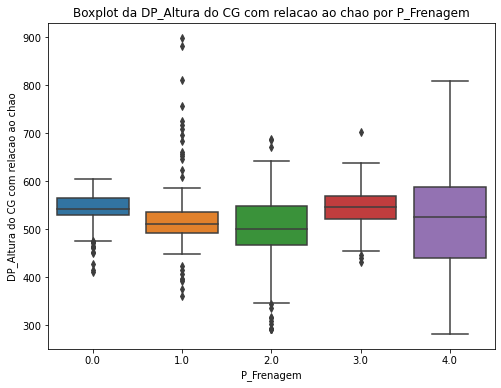

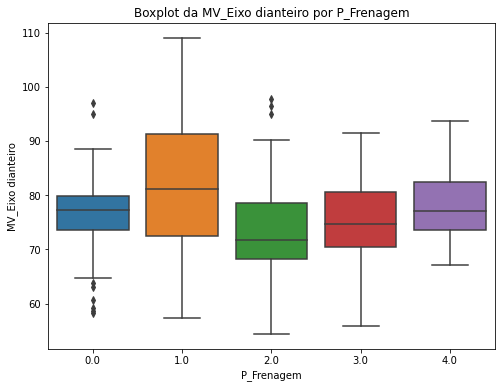

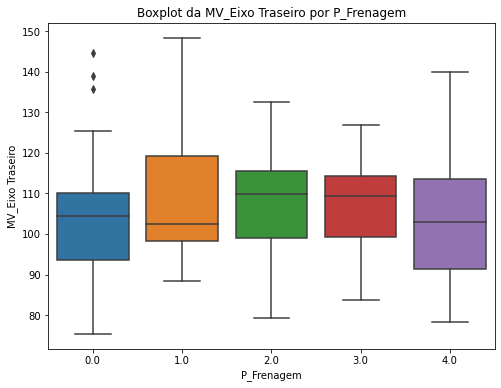

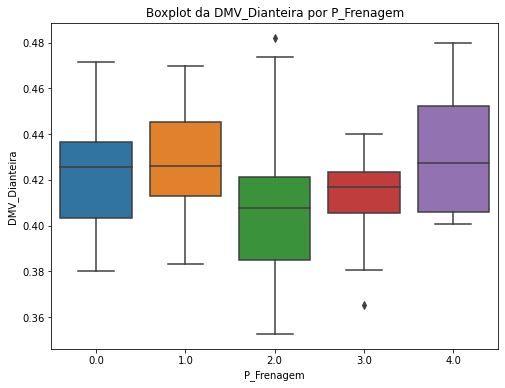

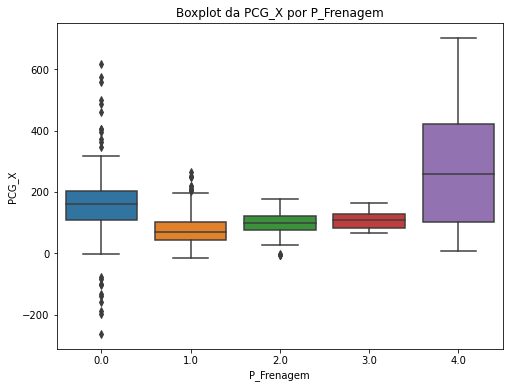

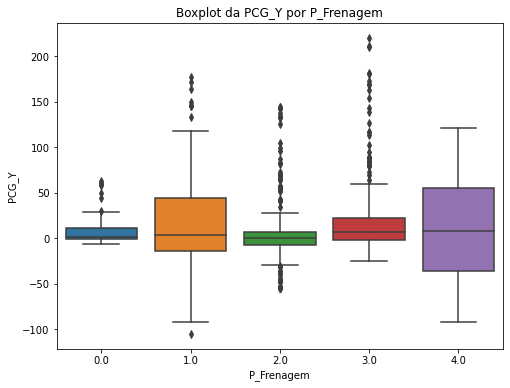

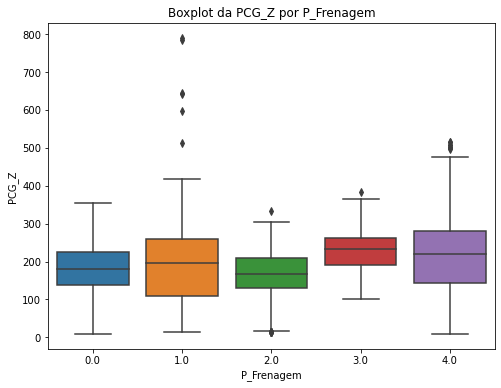

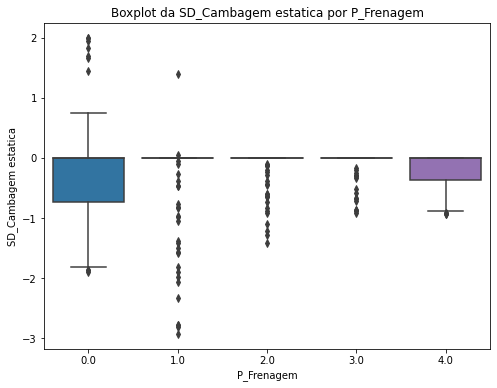

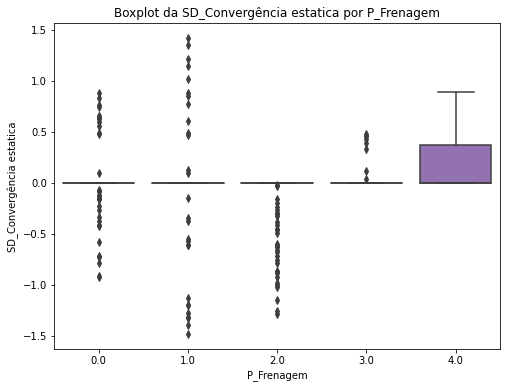

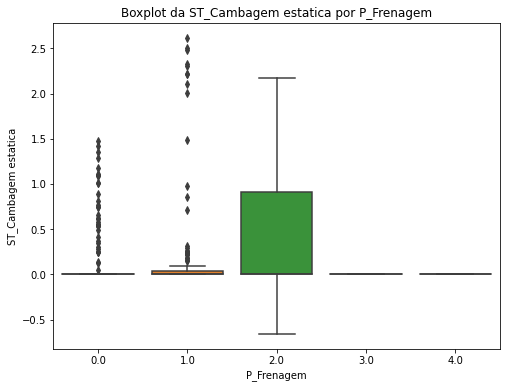

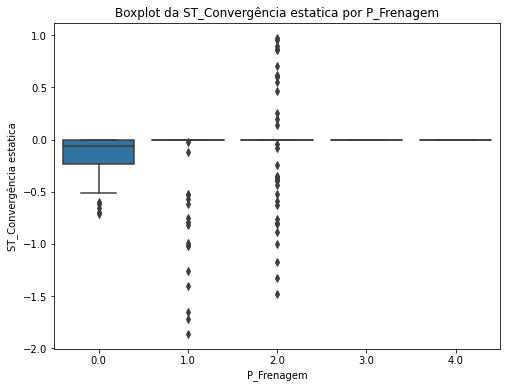

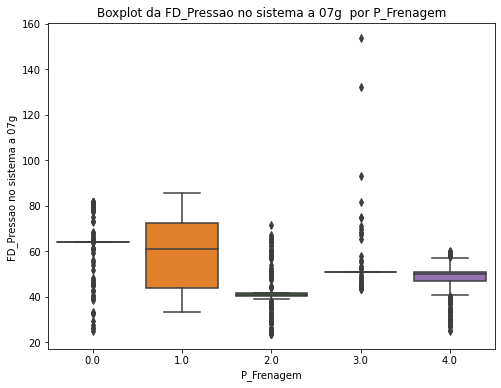

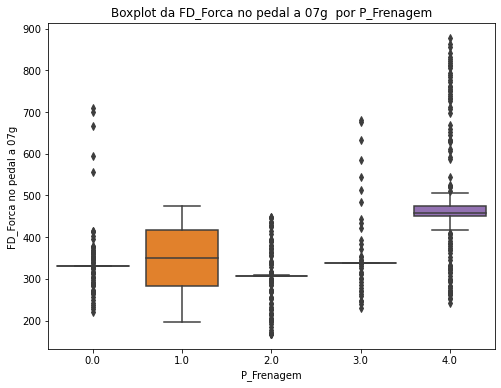

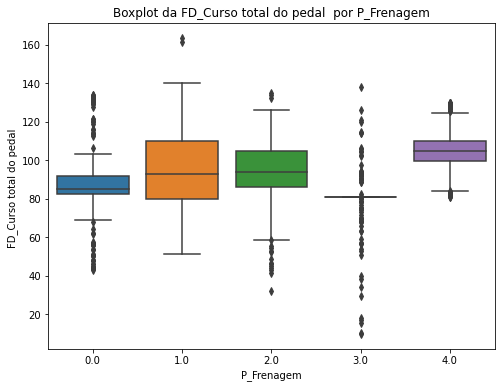

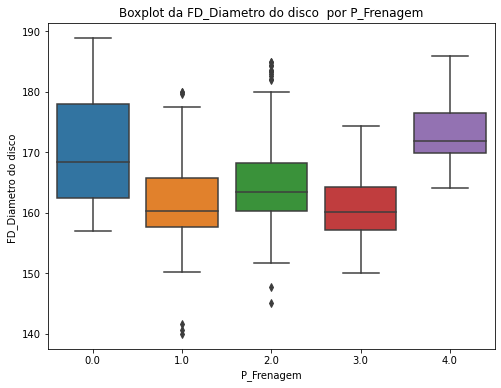

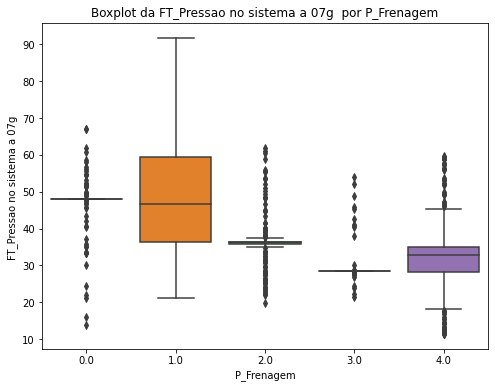

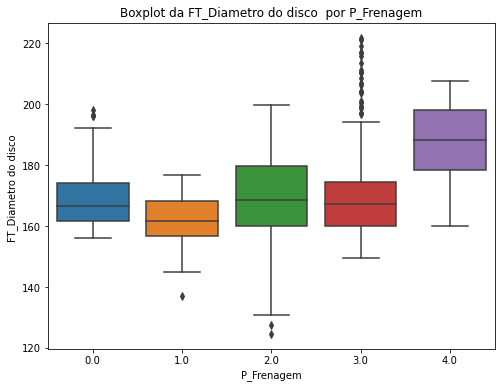

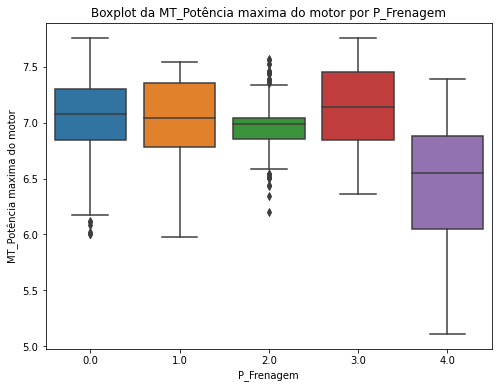

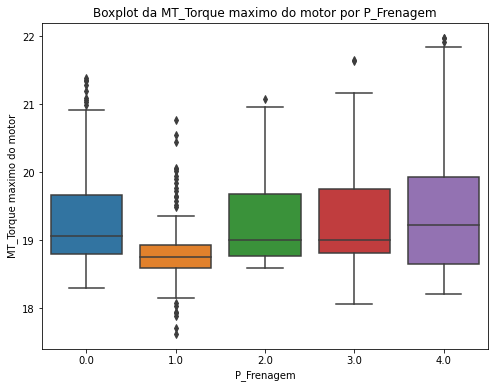

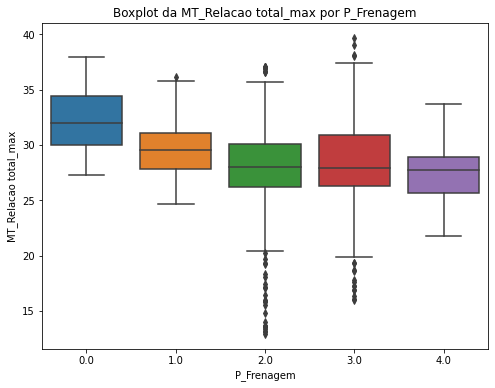

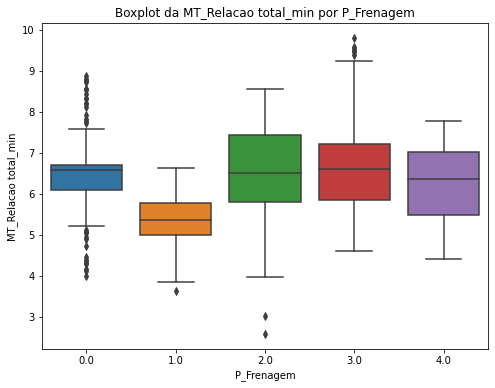

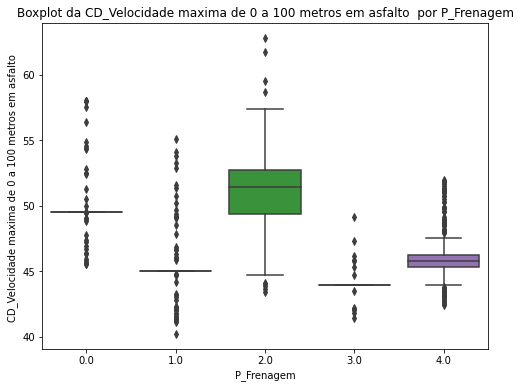

In [93]:
# Boxplots por Classes
for coluna in df_tratado.columns:
    if coluna != 'P_Frenagem':  # Excluindo a coluna de classe das análises
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='P_Frenagem', y=coluna, data=df_tratado)
        plt.title(f'Boxplot da {coluna} por P_Frenagem')
        plt.ylabel(coluna)
        plt.xlabel('P_Frenagem')
        plt.show()

In [94]:
df = df_tratado

In [ ]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Arquivo_Processado_semO.xlsx"

# Adicionar o DataFrame na planilha 'P_Frenagem'
df.to_excel(excel_writer, sheet_name='P_Frenagem', index=False)

## Análise de Variáveis

In [95]:
data_corr = df.drop(['P_Frenagem'], axis=1)
# Análise de correlação dos parâmetros
correlation = df.corr()

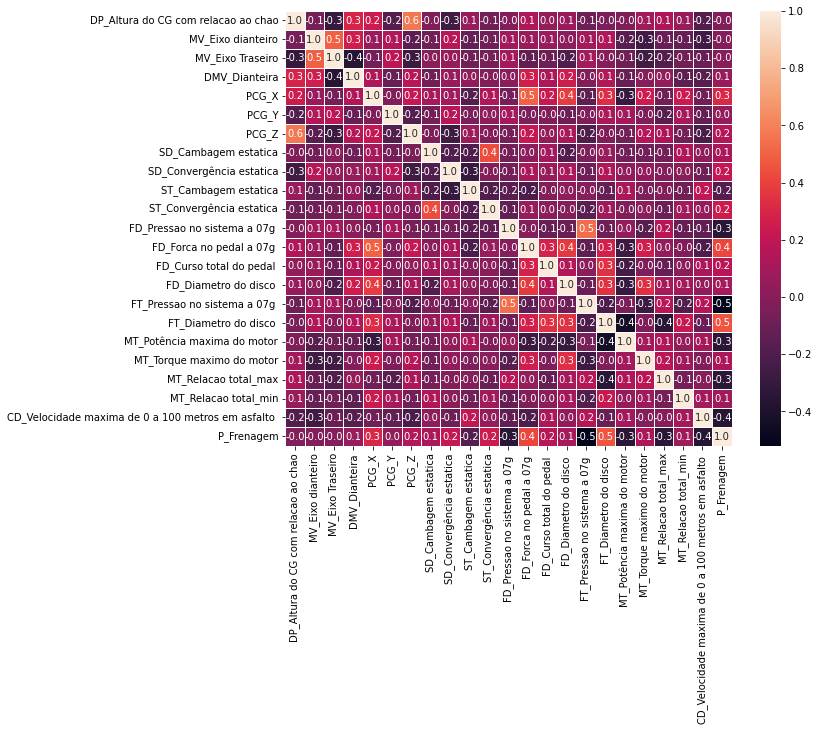

In [96]:
# Plot da matriz de correlação
plt.figure(figsize=(10, 8))

plot = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=0.5)
plt.show()

In [97]:
# Aplicar PCA para reduzir variáveis de alta correlação - Massa
variaveis_reduzidas = df[['MV_Eixo dianteiro', 'MV_Eixo Traseiro', 'DMV_Dianteira']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'MV_Eixo dianteiro',
    'MV_Eixo Traseiro',
    'DMV_Dianteira'
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 0

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'Massa', variavel_reduzida)

print(df)

          Massa  DP_Altura do CG com relacao ao chao       PCG_X      PCG_Y  \
0     27.800234                           550.000000  191.073547   0.723952   
1    -11.552356                           540.910136  146.564530  -1.527800   
2     -6.248690                           525.174720  405.269971   0.000000   
3    -22.654647                           451.574651  138.942674  -2.378915   
6      1.816175                           549.080563  144.971225  -0.755963   
...         ...                                  ...         ...        ...   
996  -11.637240                           568.409717  476.084678  41.995148   
997   25.043689                           734.333973  683.115574  42.902184   
998  -14.744354                           541.382367   28.334621 -28.890856   
999   20.512222                           519.540383  134.053421 -41.797470   
1000 -17.898509                           469.600000  629.400000   8.027403   

           PCG_Z  SD_Cambagem estatica  SD_Convergê

In [98]:
# Aplicar PCA para reduzir variáveis de alta correlação - Relação Freio
variaveis_reduzidas = df[['FD_Forca no pedal a 07g ', 'FD_Curso total do pedal ', 'FD_Diametro do disco ','FT_Diametro do disco ']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'FD_Forca no pedal a 07g ',
    'FD_Curso total do pedal ',
    'FD_Diametro do disco ',
    'FT_Diametro do disco ',
    
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 11

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'Relação Freio', variavel_reduzida)

print(df)

          Massa  DP_Altura do CG com relacao ao chao       PCG_X      PCG_Y  \
0     27.800234                           550.000000  191.073547   0.723952   
1    -11.552356                           540.910136  146.564530  -1.527800   
2     -6.248690                           525.174720  405.269971   0.000000   
3    -22.654647                           451.574651  138.942674  -2.378915   
6      1.816175                           549.080563  144.971225  -0.755963   
...         ...                                  ...         ...        ...   
996  -11.637240                           568.409717  476.084678  41.995148   
997   25.043689                           734.333973  683.115574  42.902184   
998  -14.744354                           541.382367   28.334621 -28.890856   
999   20.512222                           519.540383  134.053421 -41.797470   
1000 -17.898509                           469.600000  629.400000   8.027403   

           PCG_Z  SD_Cambagem estatica  SD_Convergê

In [99]:
# Aplicar PCA para reduzir variáveis de alta correlação - F_Pressao
variaveis_reduzidas = df[['FT_Pressao no sistema a 07g ', 'FD_Pressao no sistema a 07g ']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'FT_Pressao no sistema a 07g ',
    'FD_Pressao no sistema a 07g ',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 11

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'F_Pressao no sistema', variavel_reduzida)

print(df)

          Massa  DP_Altura do CG com relacao ao chao       PCG_X      PCG_Y  \
0     27.800234                           550.000000  191.073547   0.723952   
1    -11.552356                           540.910136  146.564530  -1.527800   
2     -6.248690                           525.174720  405.269971   0.000000   
3    -22.654647                           451.574651  138.942674  -2.378915   
6      1.816175                           549.080563  144.971225  -0.755963   
...         ...                                  ...         ...        ...   
996  -11.637240                           568.409717  476.084678  41.995148   
997   25.043689                           734.333973  683.115574  42.902184   
998  -14.744354                           541.382367   28.334621 -28.890856   
999   20.512222                           519.540383  134.053421 -41.797470   
1000 -17.898509                           469.600000  629.400000   8.027403   

           PCG_Z  SD_Cambagem estatica  SD_Convergê

In [100]:
# Aplicar PCA para reduzir variáveis de alta correlação - Motor
variaveis_reduzidas = df[['MT_Potência maxima do motor', 'MT_Torque maximo do motor','MT_Relacao total_max', 'MT_Relacao total_min']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'MT_Potência maxima do motor',
    'MT_Torque maximo do motor', 
    'MT_Relacao total_max',
    'MT_Relacao total_min'
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 11

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'Motor', variavel_reduzida)

print(df)

          Massa  DP_Altura do CG com relacao ao chao       PCG_X      PCG_Y  \
0     27.800234                           550.000000  191.073547   0.723952   
1    -11.552356                           540.910136  146.564530  -1.527800   
2     -6.248690                           525.174720  405.269971   0.000000   
3    -22.654647                           451.574651  138.942674  -2.378915   
6      1.816175                           549.080563  144.971225  -0.755963   
...         ...                                  ...         ...        ...   
996  -11.637240                           568.409717  476.084678  41.995148   
997   25.043689                           734.333973  683.115574  42.902184   
998  -14.744354                           541.382367   28.334621 -28.890856   
999   20.512222                           519.540383  134.053421 -41.797470   
1000 -17.898509                           469.600000  629.400000   8.027403   

           PCG_Z  SD_Cambagem estatica  SD_Convergê

In [101]:
# Remova a última linha do DataFrame e armazene-a em uma variável separada
dados_MB24 = df.iloc[-1]
df = df.iloc[:-1]

dados_MB24 = dados_MB24.drop('P_Frenagem')

print(dados_MB24)

Massa                                                 -17.898509
DP_Altura do CG com relacao ao chao                   469.600000
PCG_X                                                 629.400000
PCG_Y                                                   8.027403
PCG_Z                                                 189.600000
SD_Cambagem estatica                                    0.000000
SD_Convergência estatica                                0.000000
ST_Cambagem estatica                                    0.000000
ST_Convergência estatica                                0.000000
Relação Freio                                          -0.314915
F_Pressao no sistema                                   -0.924720
Motor                                                   0.963352
CD_Velocidade maxima de 0 a 100 metros em asfalto      43.000000
Name: 1000, dtype: float64


In [102]:
# Dividir o conjunto de dados em treinamento e teste
dados_treino, dados_teste = train_test_split(df, test_size=0.3)

# Separar X e Y
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

X_treino = dados_treino.iloc[:, :-1]
Y_treino = dados_treino.iloc[:, -1]

X_teste = dados_teste.iloc[:, :-1]
Y_teste = dados_teste.iloc[:, -1]

print(dados_treino)

         Massa  DP_Altura do CG com relacao ao chao       PCG_X      PCG_Y  \
597   5.715015                           541.311791  119.096612  -2.332423   
673   6.994505                           541.242074  156.002338  -1.788666   
190  -5.705009                           579.376565  153.915885  16.195325   
528   8.220572                           316.209372  122.980690 -30.870084   
12  -14.881609                           603.625863  159.871861   0.080344   
..         ...                                  ...         ...        ...   
630 -10.299974                           523.884856  121.999301  69.145672   
679   0.904575                           544.684140  107.924461  -3.727156   
643   7.266471                           501.558901  148.145960  -1.338435   
930   1.178687                           308.236934  121.423637  15.516846   
710 -14.178424                           573.319348   73.176629  15.275355   

          PCG_Z  SD_Cambagem estatica  SD_Convergência estatica

In [103]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Dados Treino\\dadostreino_fre.xlsx"

# Adicionar o DataFrame na planilha 'P_Frenagem'
df.to_excel(caminho_arquivo, sheet_name='P_Frenagem', index=False)

In [104]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Dados Teste\\dadosteste_fre.xlsx"

# Adicionar o DataFrame na planilha 'P_Frenagem'
df.to_excel(caminho_arquivo, sheet_name='P_Frenagem', index=False)

# Pré-seleção do Modelo

## Árvore de Decisão de Classificação

In [105]:
# Modelo de Árvore de Decisão de Classificação.
model_DTC = DecisionTreeClassifier()
model_DTC.fit(X_treino, Y_treino)

DecisionTreeClassifier()

## Classificação de Floresta Aleatória

In [106]:
# Modelo de Classificação de Floresta Aleatória.
model_RFC = RandomForestClassifier()
model_RFC.fit(X_treino, Y_treino)

RandomForestClassifier()

## Extreme Gradient Boosting

In [107]:
# Modelo de Extreme Gradient Boosting.
model_XGB = XGBClassifier()
model_XGB.fit(X_treino, Y_treino)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

# Refinamento do Modelo

## Árvore de Decisão de Classificação

In [108]:
# Exemplo de Tuning
param_grid = {
    'criterion': ['gini', 'entropy'],        # Avaliar a qualidade da divisão
    'max_depth': [None, 5, 10, 15],          # Profundidade máxima das árvores 
    'min_samples_split': [2, 5, 10],         # Número mínimo de amostras necessárias para dividir um nó
    'min_samples_leaf': [1, 2, 4],           # Número mínimo de amostras em uma folha
    'max_features': [None, 'sqrt', 'log2']   # Número máximo de recursos a serem considerados em cada divisão
}
grid_search = GridSearchCV(estimator=model_DTC, param_grid=param_grid, cv=5)

grid_search.fit(X_treino, Y_treino)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [109]:
# Ajustar um modelo de Árvore de Decisão
model_DTC.fit(X_treino, Y_treino)

# Configure o modelo com os melhores parâmetros
model_DTC.set_params(**best_params)

DecisionTreeClassifier(criterion='entropy', max_depth=10)

## Classificação de Floresta Aleatória

In [110]:
# Exemplo de Tuning
param_grid = {
    'n_estimators': [10, 20, 30],           # Número de árvores na floresta
    'max_depth': [None, 10, 20, 30],        # Profundidade máxima das árvores
    'min_samples_split': [2, 5, 10],        # Número mínimo de amostras necessárias para dividir um nó
    'min_samples_leaf': [1, 2, 4],          # Número mínimo de amostras em uma folha
    'max_features': ['auto', 'sqrt']        # Número máximo de recursos a serem considerados em cada divisão
}

grid_search = GridSearchCV(estimator=model_RFC, param_grid=param_grid, cv=5)

grid_search.fit(X_treino, Y_treino)

best_params_RFC = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [111]:
# Guardar os parâmetros encontrados fora do código
#melhores_parametros = grid_search.best_params_

# Salvar os melhores parâmetros em um arquivo
#joblib.dump(melhores_parametros, 'melhores_parametros_acel.pkl')

# Carregar os melhores parâmetros a partir do arquivo
#melhores_parametros = joblib.load('melhores_parametros_acel.pkl')

In [112]:
# Ajustar um modelo de Floresta Aleatória
model_RFC.fit(X_treino, Y_treino)

# Configure o modelo com os melhores parâmetros
model_RFC.set_params(**best_params_RFC)

RandomForestClassifier(max_depth=20, max_features='sqrt', n_estimators=30)

## Extreme Gradient Boosting

In [ ]:
# Exemplo de Tuning
param_grid = {
    'n_estimators': [100, 200, 300],       # Número de árvores na floresta
    'max_depth': [3, 4, 5],                # Profundidade máxima das árvores
    'learning_rate': [0.1, 0.01],          # Taxa de aprendizado
    'subsample': [0.8, 0.9, 1.0],          # Fração de amostras usadas para treinamento de cada árvore
    'min_child_weight': [1, 5, 10],        # Peso mínimo das amostras necessárias em uma folha
    'gamma': [0, 0.1, 0.2],                # Regularização gamma (parâmetro de penalização)
}

grid_search = GridSearchCV(estimator=model_XGB, param_grid=param_grid, cv=5)

grid_search.fit(X_treino, Y_treino)

best_params_XGB = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [ ]:
# Ajustar um modelo de XGBoost
model_XGB.fit(X_treino, Y_treino)

# Configure o modelo com os melhores parâmetros
model_XGB.set_params(**best_params_XGB)

# Validação Cruzada

In [ ]:
# Número de classes
n_classes = 5

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
#kfold = StratifiedKFold(n_splits = 5, shuffle = True) # Caso uma classe prevaleça muita em função da outra

## Árvore de Decisão de Classificação

In [ ]:
# Receiver operating characteristic — ROC

# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = cross_val_predict(model_DTC, X_treino, Y_treino, cv=kfold, method='predict_proba')

# Calcula as curvas ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plote as curvas ROC para cada classe
fig, ax = plt.subplots(figsize=(12, 4))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color, lw=2, label='Classe {}'.format(i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curvas ROC para DTC', fontsize=14)
plt.show()

In [ ]:
# Área sob a Curva
print('Área sob a curva ROC DTC: {:.4f}'.format(roc_auc_score(Y_treino, y_scores, multi_class='ovr', average='macro')))

## Classificação de Floresta Aleatória

In [ ]:
# Receiver operating characteristic — ROC

# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = cross_val_predict(model_RFC, X_treino, Y_treino, cv=kfold, method='predict_proba')

# Calcula as curvas ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plote as curvas ROC para cada classe
fig, ax = plt.subplots(figsize=(12, 4))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color, lw=2, label='Classe {}'.format(i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curvas ROC para RFC', fontsize=14)
plt.show()

In [ ]:
# Área sob a Curva
print('Área sob a curva ROC RFC: {:.4f}'.format(roc_auc_score(Y_treino, y_scores, multi_class='ovr', average='macro')))

## Extreme Gradient Boosting

In [ ]:
# Receiver operating characteristic — ROC

# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = cross_val_predict(model_XGB, X_treino, Y_treino, cv=kfold, method='predict_proba')

# Calcula as curvas ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plote as curvas ROC para cada classe
fig, ax = plt.subplots(figsize=(12, 4))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color, lw=2, label='Classe {}'.format(i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curvas ROC para XGB', fontsize=14)
plt.show()

In [ ]:
# Área sob a Curva
print('Área sob a curva ROC XGB: {:.4f}'.format(roc_auc_score(Y_treino, y_scores, multi_class='ovr', average='macro')))

# Desempate

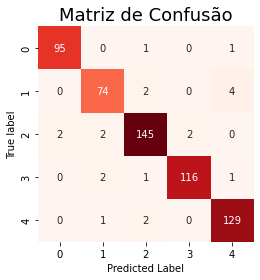

In [47]:
# Matriz de Confusão
Y_pred = cross_val_predict(model_RFC, X_treino, Y_treino, cv=kfold) # Checar Modelo

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(Y_treino, Y_pred), annot=True, ax=ax, fmt='d', cmap='Reds', cbar=False, square=True)
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

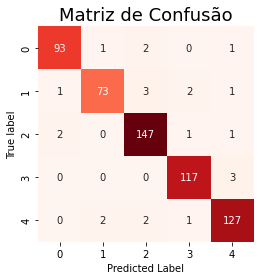

In [48]:
# Matriz de Confusão
Y_pred = cross_val_predict(model_XGB, X_treino, Y_treino, cv=kfold) # Checar Modelo

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(Y_treino, Y_pred), annot=True, ax=ax, fmt='d', cmap='Reds', cbar=False, square=True)
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

# Treinamento

In [49]:
# Treinamento do modelo 
model_XGB.fit(X_treino, Y_treino) # Checar modelo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

# Avaliação

In [50]:
# Fazer previsões no conjunto de teste
Y_pred = model_XGB.predict(X_teste)

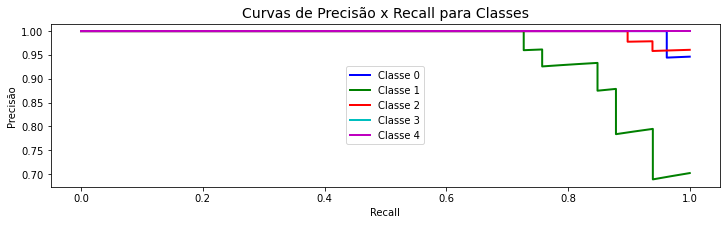

In [51]:
# Comparar scores de Previsão e Recall
# Converta Y_teste para uma matriz binária de classes
Y_bin = label_binarize(Y_teste, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = model_XGB.predict_proba(X_teste)

# Calcula as curvas de precisão e recall para cada classe
precisions = dict()
recalls = dict()
for i in range(5):
    precision, recall, _ = precision_recall_curve(Y_bin[:, i], y_scores[:, i])
    precisions[i] = precision
    recalls[i] = recall

# Plote as curvas de precisão e recall para cada classe
fig, ax = plt.subplots(figsize=(12, 3))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(recalls[i], precisions[i], color, lw=2, label='Classe {}'.format(i))

plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.legend(loc='center')
plt.title('Curvas de Precisão x Recall para Classes', fontsize=14)
plt.show()

In [52]:
# Supondo que Y_teste é um array de rótulos multiclasse
# E Y_pred é a saída do modelo

# Binarize as saídas e rótulos
Y_teste_bin = label_binarize(Y_teste, classes=list(range(5)))
Y_pred_bin = label_binarize(Y_pred, classes=list(range(5)))

# Calcule a AUC para cada classe
auc_scores = []
for i in range(5):
    auc_score_i = roc_auc_score(Y_teste_bin[:, i], Y_pred_bin[:, i])
    auc_scores.append(auc_score_i)

# Calcule a média do AUC
media_auc = sum(auc_scores) / len(auc_scores)

print(f'Média do AUC: {media_auc:.4f}')

Média do AUC: 0.9776


## Análise de Variáveis

In [53]:
# Analisar variáveis que mais afetam o modelo
importances = model_XGB.feature_importances_

# Classifique as importâncias das características
indices_ordenados = np.argsort(importances)[::-1]

print(importances)

[0.03288488 0.0781152  0.04416207 0.03460243 0.05151795 0.06541003
 0.158333   0.02383861 0.03239879 0.1652059  0.1921363  0.12139493]


[20:06:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 98%|===================| 1221/1245 [00:20<00:00]        

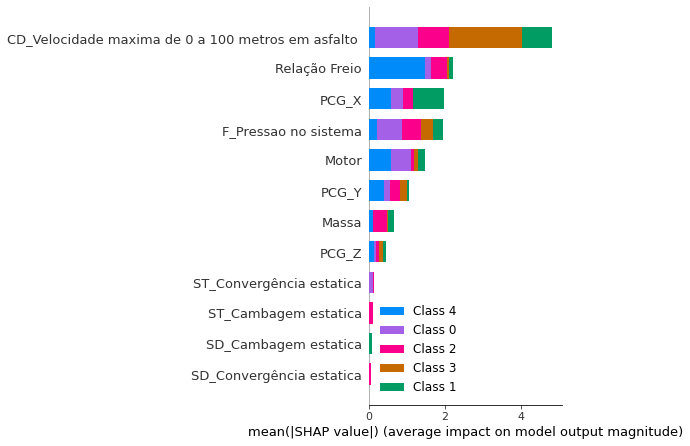

In [54]:
# Crie um objeto explainer
explainer = shap.Explainer(model_XGB, X_teste)

# Calcule os valores Shapley para um exemplo de dado específico
shap_values = explainer.shap_values(X_teste)

# Visualize os valores Shapley
shap.summary_plot(shap_values, X_teste)

# Predição

In [ ]:
# Valor único para fazer a previsão
X_prev = dados_MB24

# Faça a previsão
previsao = modelo_carregado.predict(X_prev)

# Imprima a previsão
print(f'A previsão para X_prev é: {previsao[0]:.2f}')